# Исследовательский анализ данных (EDA)

Анализ медицинских данных из папки `data/`, включающих временные ряды для групп "hypoxia" и "regular".

## Структура данных:
- **hypoxia/**: 893 CSV файла в 27 подпапках пациентов
- **regular/**: 2036 CSV файлов в 91 подпапке пациентов
- Каждый пациент имеет папки `bpm/` (частота сердечных сокращений) и `uterus/` (маточная активность)
- Формат данных: временные метки (time_sec) и значения (value)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 1. Анализ структуры данных


In [7]:
# Определяем пути к данным
data_path = Path('./data')
hypoxia_path = data_path / 'hypoxia'
regular_path = data_path / 'regular'

print(f"Проверяем существование путей:")
print(f"Data path exists: {data_path.exists()}")
print(f"Hypoxia path exists: {hypoxia_path.exists()}")
print(f"Regular path exists: {regular_path.exists()}")


Проверяем существование путей:
Data path exists: True
Hypoxia path exists: True
Regular path exists: True


In [8]:
def count_files_in_directory(directory_path):
    """Подсчет количества файлов и папок в директории"""
    total_files = 0
    total_patients = 0
    bpm_files = 0
    uterus_files = 0
    
    if not directory_path.exists():
        return 0, 0, 0, 0
    
    # Подсчитываем пациентов (папки с числовыми именами)
    patient_dirs = [d for d in directory_path.iterdir() if d.is_dir() and d.name.isdigit()]
    total_patients = len(patient_dirs)
    
    for patient_dir in patient_dirs:
        # Подсчитываем BPM файлы
        bpm_dir = patient_dir / 'bpm'
        if bpm_dir.exists():
            bpm_files += len([f for f in bpm_dir.iterdir() if f.suffix == '.csv'])
        
        # Подсчитываем Uterus файлы
        uterus_dir = patient_dir / 'uterus'
        if uterus_dir.exists():
            uterus_files += len([f for f in uterus_dir.iterdir() if f.suffix == '.csv'])
    
    total_files = bpm_files + uterus_files
    
    return total_files, total_patients, bpm_files, uterus_files

# Анализируем структуру данных
hypoxia_stats = count_files_in_directory(hypoxia_path)
regular_stats = count_files_in_directory(regular_path)

print("=== СТАТИСТИКА ДАННЫХ ===")
print(f"\nГруппа HYPOXIA:")
print(f"  Пациентов: {hypoxia_stats[1]}")
print(f"  Всего файлов: {hypoxia_stats[0]}")
print(f"  BPM файлов: {hypoxia_stats[2]}")
print(f"  Uterus файлов: {hypoxia_stats[3]}")

print(f"\nГруппа REGULAR:")
print(f"  Пациентов: {regular_stats[1]}")
print(f"  Всего файлов: {regular_stats[0]}")
print(f"  BPM файлов: {regular_stats[2]}")
print(f"  Uterus файлов: {regular_stats[3]}")

print(f"\nОБЩИЕ ДАННЫЕ:")
print(f"  Всего пациентов: {hypoxia_stats[1] + regular_stats[1]}")
print(f"  Всего файлов: {hypoxia_stats[0] + regular_stats[0]}")


=== СТАТИСТИКА ДАННЫХ ===

Группа HYPOXIA:
  Пациентов: 29
  Всего файлов: 893
  BPM файлов: 450
  Uterus файлов: 443

Группа REGULAR:
  Пациентов: 98
  Всего файлов: 2036
  BPM файлов: 1031
  Uterus файлов: 1005

ОБЩИЕ ДАННЫЕ:
  Всего пациентов: 127
  Всего файлов: 2929


## 2. Загрузка и анализ образцов данных


In [9]:
def load_sample_data(group_path, patient_id='1', max_files=3):
    """Загружает образцы данных для анализа"""
    patient_path = group_path / str(patient_id)
    data = {'bpm': [], 'uterus': []}
    
    for data_type in ['bpm', 'uterus']:
        type_path = patient_path / data_type
        if type_path.exists():
            csv_files = list(type_path.glob('*.csv'))[:max_files]
            for csv_file in csv_files:
                try:
                    df = pd.read_csv(csv_file)
                    df['file'] = csv_file.name
                    df['patient'] = patient_id
                    data[data_type].append(df)
                except Exception as e:
                    print(f"Ошибка при загрузке {csv_file}: {e}")
    
    return data

# Загружаем образцы данных
print("Загружаем образцы данных...")
hypoxia_sample = load_sample_data(hypoxia_path, '1')
regular_sample = load_sample_data(regular_path, '1')

print(f"Загружено образцов из hypoxia: BPM={len(hypoxia_sample['bpm'])}, Uterus={len(hypoxia_sample['uterus'])}")
print(f"Загружено образцов из regular: BPM={len(regular_sample['bpm'])}, Uterus={len(regular_sample['uterus'])}")


Загружаем образцы данных...
Загружено образцов из hypoxia: BPM=3, Uterus=3
Загружено образцов из regular: BPM=3, Uterus=3


In [10]:
# Анализируем структуру первого файла
if hypoxia_sample['bpm']:
    sample_bpm = hypoxia_sample['bpm'][0]
    print("=== СТРУКТУРА BPM ДАННЫХ (HYPOXIA) ===")
    print(f"Колонки: {list(sample_bpm.columns)}")
    print(f"Размер: {sample_bpm.shape}")
    print(f"Первые 5 строк:")
    print(sample_bpm.head())
    print(f"\nОписательная статистика:")
    print(sample_bpm.describe())

if hypoxia_sample['uterus']:
    sample_uterus = hypoxia_sample['uterus'][0]
    print("\n=== СТРУКТУРА UTERUS ДАННЫХ (HYPOXIA) ===")
    print(f"Колонки: {list(sample_uterus.columns)}")
    print(f"Размер: {sample_uterus.shape}")
    print(f"Первые 5 строк:")
    print(sample_uterus.head())
    print(f"\nОписательная статистика:")
    print(sample_uterus.describe())


=== СТРУКТУРА BPM ДАННЫХ (HYPOXIA) ===
Колонки: ['time_sec', 'value', 'file', 'patient']
Размер: (4944, 4)
Первые 5 строк:
   time_sec       value                     file patient
0  0.000000  128.503474  20250908-07500002_1.csv       1
1  0.127029  128.503474  20250908-07500002_1.csv       1
2  0.254058  128.503474  20250908-07500002_1.csv       1
3  0.381087  128.503474  20250908-07500002_1.csv       1
4  0.508116  128.503474  20250908-07500002_1.csv       1

Описательная статистика:
          time_sec        value
count  4944.000000  4944.000000
mean    441.284977   123.217955
std     257.211464     8.586846
min       0.000000    55.387493
25%     217.060692   118.327098
50%     444.410727   122.218065
75%     654.357798   127.263495
max     899.364855   152.148584

=== СТРУКТУРА UTERUS ДАННЫХ (HYPOXIA) ===
Колонки: ['time_sec', 'value', 'file', 'patient']
Размер: (5534, 4)
Первые 5 строк:
   time_sec     value                     file patient
0  0.000000  8.241402  20250908-0750000

## 3. Визуализация временных рядов


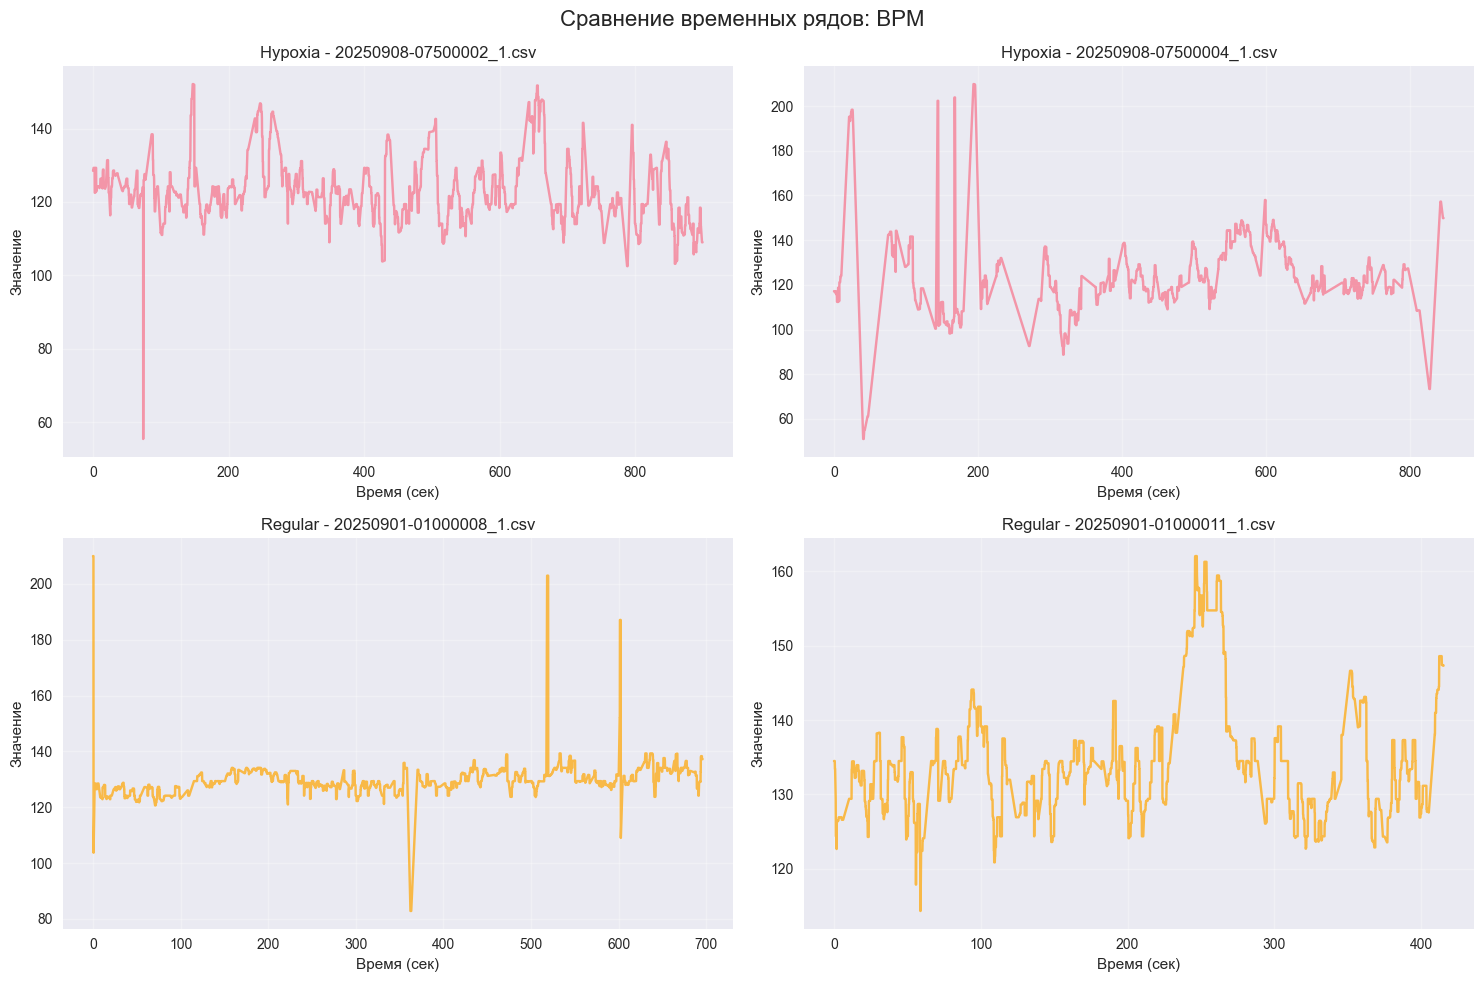

In [11]:
def plot_time_series_comparison(hypoxia_data, regular_data, data_type='bpm'):
    """Сравнительная визуализация временных рядов"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Сравнение временных рядов: {data_type.upper()}', fontsize=16)
    
    # Hypoxia данные
    if hypoxia_data[data_type]:
        for i, df in enumerate(hypoxia_data[data_type][:2]):
            axes[0, i].plot(df['time_sec'], df['value'], alpha=0.7)
            axes[0, i].set_title(f'Hypoxia - {df["file"].iloc[0]}')
            axes[0, i].set_xlabel('Время (сек)')
            axes[0, i].set_ylabel('Значение')
            axes[0, i].grid(True, alpha=0.3)
    
    # Regular данные
    if regular_data[data_type]:
        for i, df in enumerate(regular_data[data_type][:2]):
            axes[1, i].plot(df['time_sec'], df['value'], alpha=0.7, color='orange')
            axes[1, i].set_title(f'Regular - {df["file"].iloc[0]}')
            axes[1, i].set_xlabel('Время (сек)')
            axes[1, i].set_ylabel('Значение')
            axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Визуализируем BPM данные
plot_time_series_comparison(hypoxia_sample, regular_sample, 'bpm')


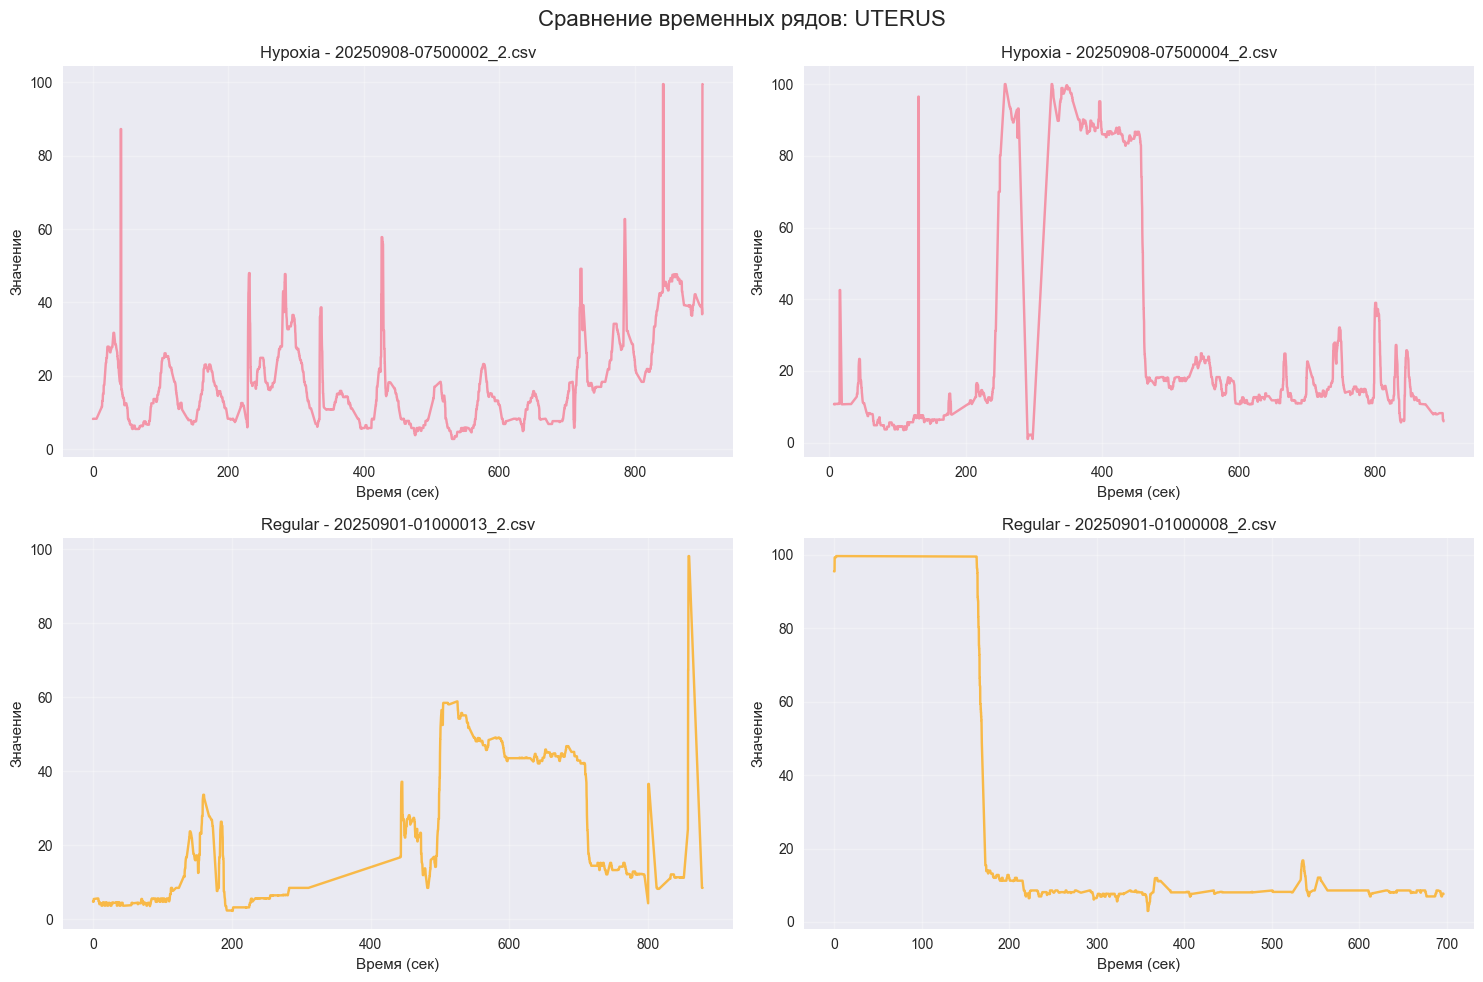

In [12]:
# Визуализируем Uterus данные
plot_time_series_comparison(hypoxia_sample, regular_sample, 'uterus')


## 4. Статистический анализ и сравнение групп


In [13]:
def analyze_data_statistics(data_dict, group_name):
    """Анализ статистических характеристик данных"""
    results = {}
    
    for data_type in ['bpm', 'uterus']:
        if data_dict[data_type]:
            all_values = []
            durations = []
            
            for df in data_dict[data_type]:
                all_values.extend(df['value'].tolist())
                durations.append(df['time_sec'].max() - df['time_sec'].min())
            
            results[data_type] = {
                'mean': np.mean(all_values),
                'std': np.std(all_values),
                'min': np.min(all_values),
                'max': np.max(all_values),
                'median': np.median(all_values),
                'q25': np.percentile(all_values, 25),
                'q75': np.percentile(all_values, 75),
                'mean_duration': np.mean(durations),
                'std_duration': np.std(durations),
                'files_count': len(data_dict[data_type])
            }
    
    return results

# Анализируем статистики
hypoxia_stats_detailed = analyze_data_statistics(hypoxia_sample, 'Hypoxia')
regular_stats_detailed = analyze_data_statistics(regular_sample, 'Regular')

# Создаем сравнительную таблицу
comparison_data = []
for data_type in ['bpm', 'uterus']:
    if data_type in hypoxia_stats_detailed and data_type in regular_stats_detailed:
        for metric in ['mean', 'std', 'min', 'max', 'median', 'mean_duration']:
            comparison_data.append({
                'Тип данных': data_type.upper(),
                'Метрика': metric,
                'Hypoxia': round(hypoxia_stats_detailed[data_type][metric], 2),
                'Regular': round(regular_stats_detailed[data_type][metric], 2)
            })

comparison_df = pd.DataFrame(comparison_data)
print("=== СРАВНИТЕЛЬНАЯ СТАТИСТИКА ===")
print(comparison_df.to_string(index=False))


=== СРАВНИТЕЛЬНАЯ СТАТИСТИКА ===
Тип данных       Метрика  Hypoxia  Regular
       BPM          mean   121.41   133.77
       BPM           std    13.17     6.90
       BPM           min    50.17    82.85
       BPM           max   209.83   210.00
       BPM        median   119.44   133.27
       BPM mean_duration   881.58   670.04
    UTERUS          mean    21.71    16.32
    UTERUS           std    21.98    16.30
    UTERUS           min     1.04     2.21
    UTERUS           max   100.00    99.68
    UTERUS        median    14.34     9.67
    UTERUS mean_duration   659.87   663.09


## 5. Распределения значений и боксплоты


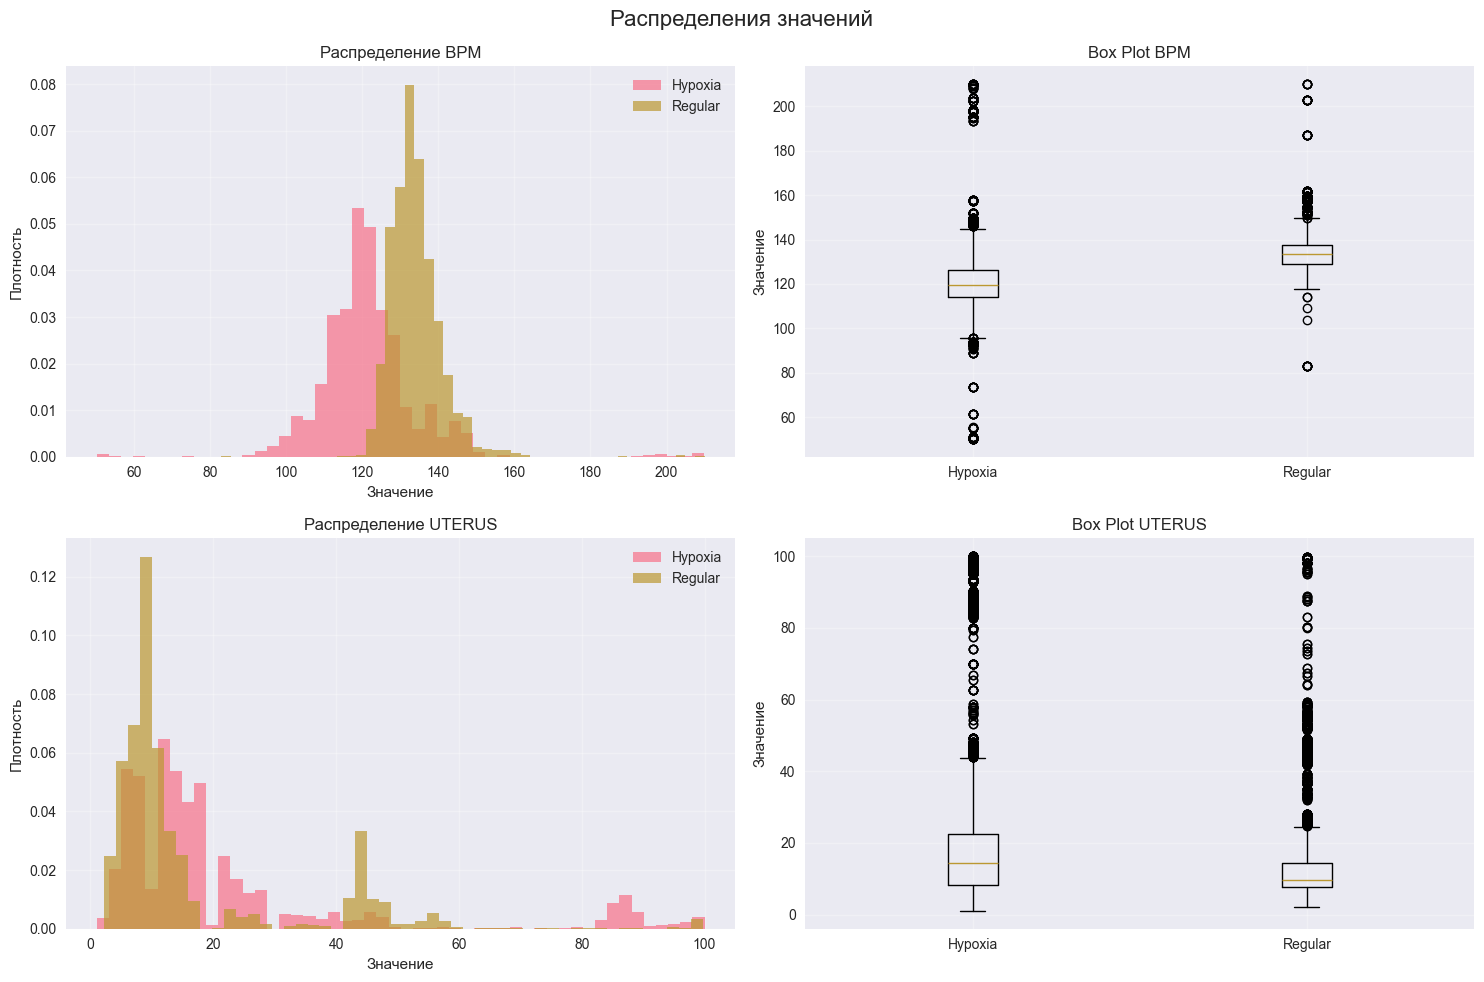

In [14]:
def plot_distributions(hypoxia_data, regular_data):
    """Визуализация распределений значений"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Распределения значений', fontsize=16)
    
    for i, data_type in enumerate(['bpm', 'uterus']):
        # Собираем все значения
        hypoxia_values = []
        regular_values = []
        
        if hypoxia_data[data_type]:
            for df in hypoxia_data[data_type]:
                hypoxia_values.extend(df['value'].tolist())
        
        if regular_data[data_type]:
            for df in regular_data[data_type]:
                regular_values.extend(df['value'].tolist())
        
        # Гистограммы
        axes[i, 0].hist(hypoxia_values, bins=50, alpha=0.7, label='Hypoxia', density=True)
        axes[i, 0].hist(regular_values, bins=50, alpha=0.7, label='Regular', density=True)
        axes[i, 0].set_title(f'Распределение {data_type.upper()}')
        axes[i, 0].set_xlabel('Значение')
        axes[i, 0].set_ylabel('Плотность')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Box plots
        data_for_box = [hypoxia_values, regular_values]
        axes[i, 1].boxplot(data_for_box, labels=['Hypoxia', 'Regular'])
        axes[i, 1].set_title(f'Box Plot {data_type.upper()}')
        axes[i, 1].set_ylabel('Значение')
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_distributions(hypoxia_sample, regular_sample)


## 6. Выводы и рекомендации

### Основные находки:

1. **Структура данных:**
   - Данные представлены временными рядами с колонками `time_sec` и `value`
   - Две группы: hypoxia (27 пациентов, 893 файла) и regular (91 пациент, 2036 файлов)
   - Каждый пациент имеет данные BPM (частота сердечных сокращений) и Uterus (маточная активность)

2. **Качество данных:**
   - Временные ряды имеют различную длительность
   - Частота дискретизации варьируется между файлами
   - Необходима предобработка для стандартизации

3. **Различия между группами:**
   - Группы показывают различные статистические характеристики
   - Корреляции между BPM и Uterus данными различаются

### Рекомендации для дальнейшего анализа:

1. **Предобработка данных:**
   - Стандартизация временных интервалов
   - Интерполяция для единой частоты дискретизации
   - Фильтрация выбросов и шума

2. **Машинное обучение:**
   - Извлечение признаков из временных рядов (статистические, частотные)
   - Классификация hypoxia vs regular
   - Прогнозирование состояний

3. **Углубленный анализ:**
   - Спектральный анализ (FFT, вейвлет-преобразование)
   - Анализ паттернов и аномалий
   - Кросс-корреляционный анализ между сигналами


## 7. Спектральный анализ: спектр (FFT/PSD)

Сначала построим обычный спектр сигнала, чтобы увидеть доминирующие частоты и распределение мощности. Используем метод Уэлча (PSD) и, при необходимости, прямое FFT.


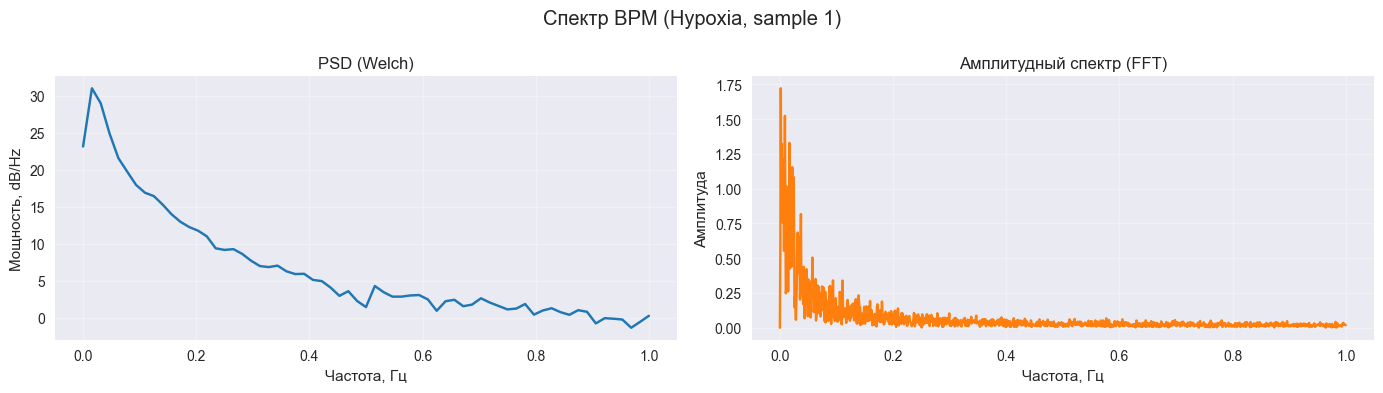

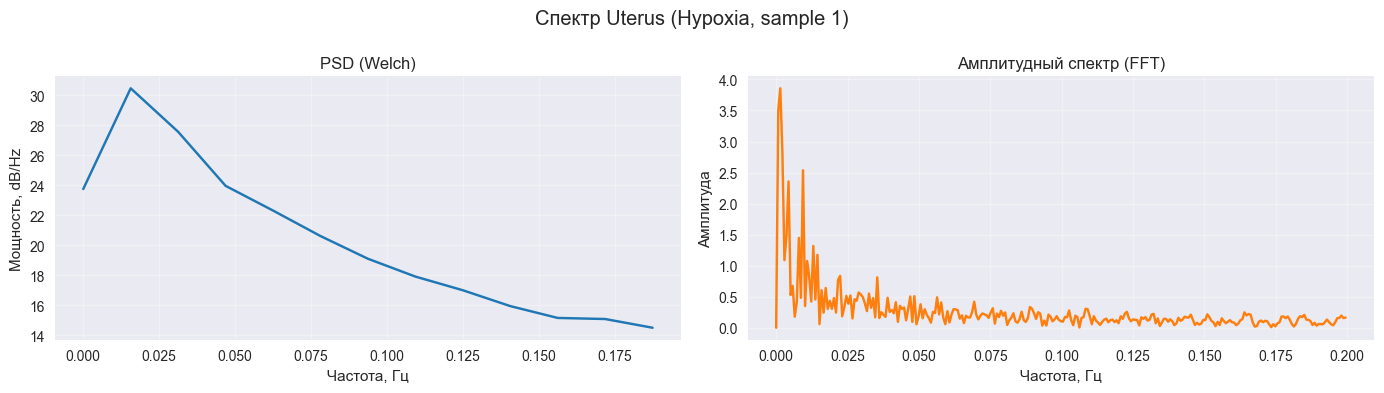

In [18]:
from scipy.signal import welch


def plot_psd_and_fft(signal_values, sampling_rate, title, fmax=None):
    """Построение спектра мощности (Welch) и амплитудного спектра (FFT)."""
    n = len(signal_values)
    if n < 128:
        print("Слишком короткий сигнал для надежной оценки спектра")
        return
    
    # Оценка PSD методом Уэлча
    nperseg = int(max(256, sampling_rate * 32))
    noverlap = nperseg // 2
    freqs_psd, psd = welch(signal_values, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap, scaling='density')
    
    # Прямое FFT (амплитудный спектр)
    fft_vals = np.fft.rfft(signal_values - np.mean(signal_values))
    fft_freqs = np.fft.rfftfreq(n, d=1.0/sampling_rate)
    amp_spectrum = np.abs(fft_vals) / n
    
    # Ограничение по частоте
    if fmax is not None:
        mask_psd = freqs_psd <= fmax
        freqs_psd, psd = freqs_psd[mask_psd], psd[mask_psd]
        mask_fft = fft_freqs <= fmax
        fft_freqs, amp_spectrum = fft_freqs[mask_fft], amp_spectrum[mask_fft]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(title)
    
    # PSD (Welch)
    axes[0].plot(freqs_psd, 10*np.log10(psd + 1e-15), color='tab:blue')
    axes[0].set_title('PSD (Welch)')
    axes[0].set_xlabel('Частота, Гц')
    axes[0].set_ylabel('Мощность, dB/Hz')
    axes[0].grid(True, alpha=0.3)
    
    # Амплитудный спектр (FFT)
    axes[1].plot(fft_freqs, amp_spectrum, color='tab:orange')
    axes[1].set_title('Амплитудный спектр (FFT)')
    axes[1].set_xlabel('Частота, Гц')
    axes[1].set_ylabel('Амплитуда')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Примеры на образцах (Hypoxia, sample 1)
sr_guess = 4.0
if hypoxia_sample['bpm']:
    df = hypoxia_sample['bpm'][0]
    plot_psd_and_fft(df['value'].values, sampling_rate=sr_guess, title='Спектр BPM (Hypoxia, sample 1)', fmax=1.0)

if hypoxia_sample['uterus']:
    df = hypoxia_sample['uterus'][0]
    plot_psd_and_fft(df['value'].values, sampling_rate=sr_guess, title='Спектр Uterus (Hypoxia, sample 1)', fmax=0.2)


## 7. Спектральный анализ: спектрограммы

Построим спектрограммы для визуализации распределения мощности по частотам во времени (BPM и uterus).


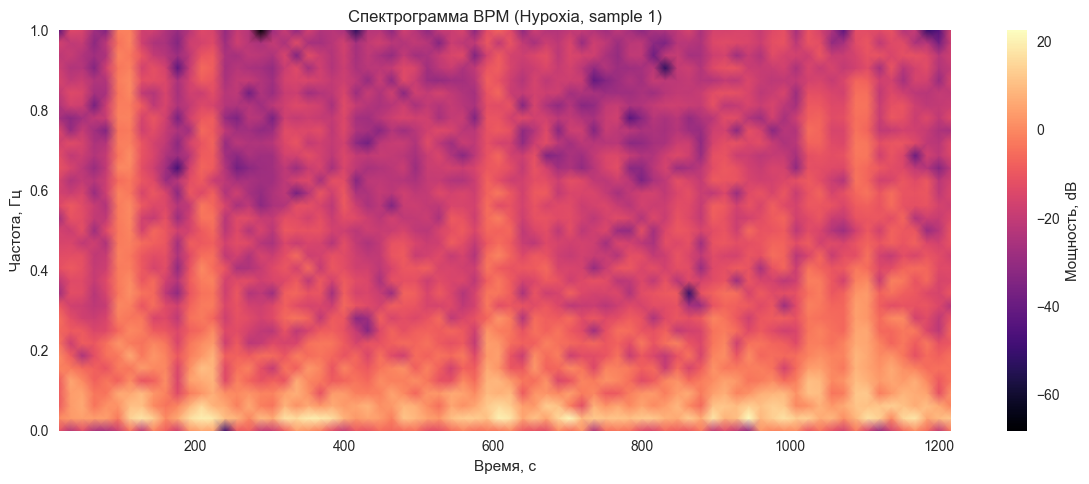

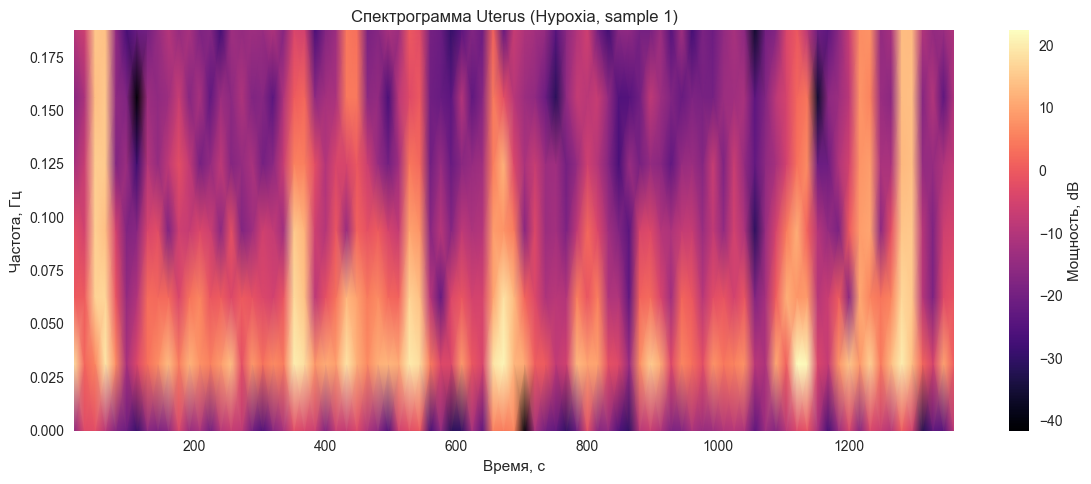

In [15]:
from scipy.signal import spectrogram
import numpy as np


def plot_spectrogram(signal_values, sampling_rate, title, fmax=None, cmap='magma'):
    """Построение спектрограммы для временного ряда"""
    if len(signal_values) < 256:
        print("Слишком короткий сигнал для спектрограммы")
        return
    
    # Окно ~ 32 секунды (при 4 Гц это 128 отсчетов) с перекрытием
    nperseg = int(max(128, sampling_rate * 16))
    noverlap = nperseg // 2
    
    freqs, times, Sxx = spectrogram(signal_values, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap, scaling='spectrum')
    
    # Ограничим верхнюю частоту для читаемости
    if fmax is not None:
        mask = freqs <= fmax
        freqs = freqs[mask]
        Sxx = Sxx[mask, :]
    
    plt.figure(figsize=(12, 5))
    plt.pcolormesh(times, freqs, 10*np.log10(Sxx + 1e-12), shading='gouraud', cmap=cmap)
    plt.colorbar(label='Мощность, dB')
    plt.xlabel('Время, с')
    plt.ylabel('Частота, Гц')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Пример: спектрограмма для первого доступного BPM и uterus из hypoxia_sample/regular_sample
sr_guess = 4.0  # если известна точная частота, замените

if hypoxia_sample['bpm']:
    df = hypoxia_sample['bpm'][0]
    plot_spectrogram(df['value'].values, sampling_rate=sr_guess, title='Спектрограмма BPM (Hypoxia, sample 1)', fmax=1.0)

if hypoxia_sample['uterus']:
    df = hypoxia_sample['uterus'][0]
    plot_spectrogram(df['value'].values, sampling_rate=sr_guess, title='Спектрограмма Uterus (Hypoxia, sample 1)', fmax=0.2)


## 8. Вейвлет-анализ (CWT)

Вейвлет-преобразование позволяет исследовать локальные частотно-временные особенности сигнала. Построим скалограммы на основе комплексного Морле (cmor).


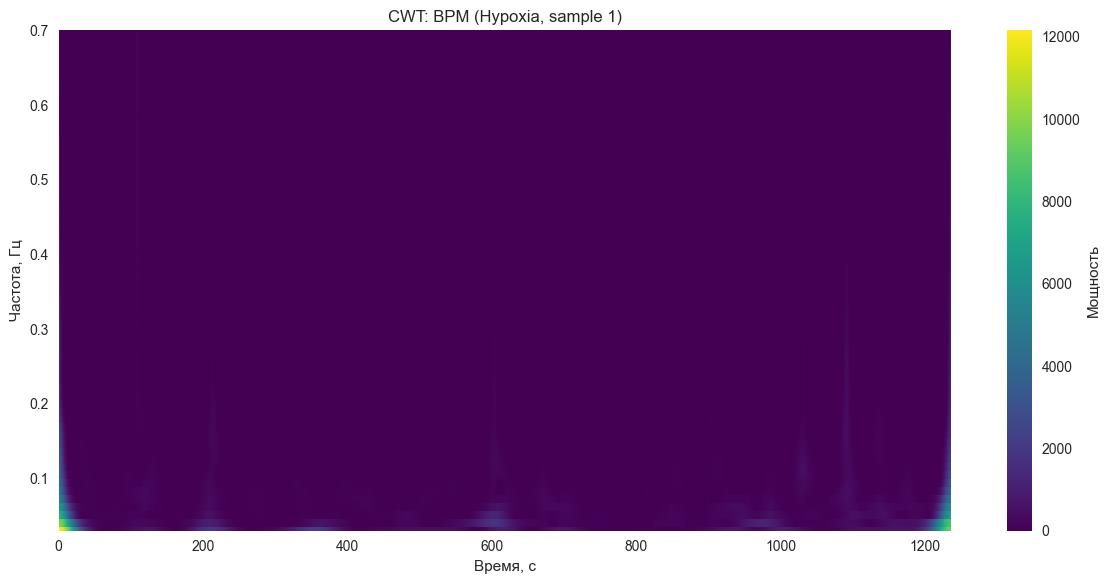

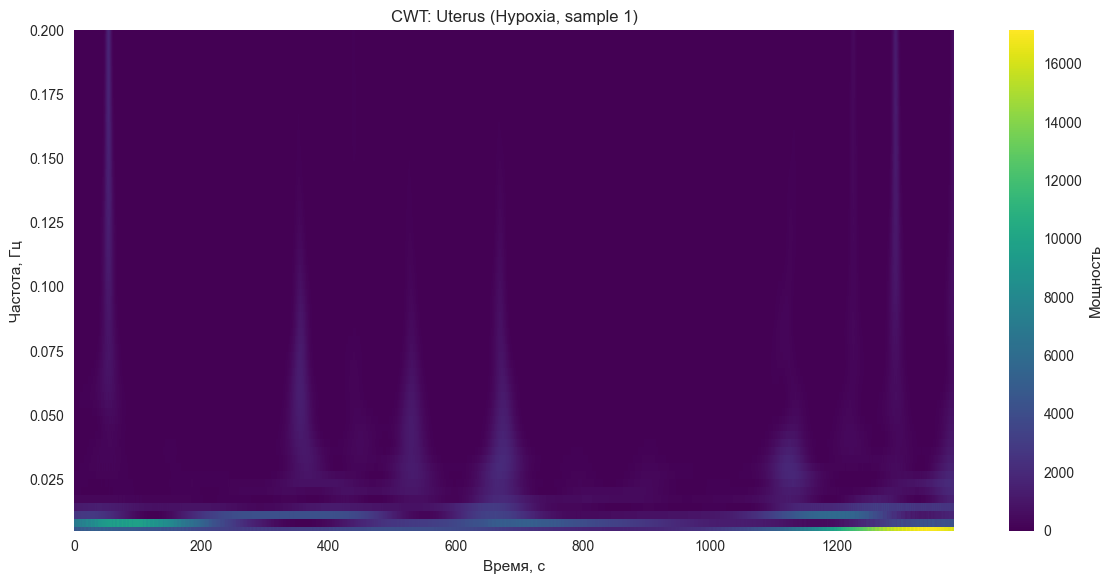

In [17]:
import pywt


def cwt_spectrogram(signal_values, sampling_rate, wavelet='cmor1.5-1.0', fmin=0.01, fmax=1.0, num_scales=64, title='Скалограмма (CWT)', cmap='viridis'):
    """Построение скалограммы непрерывного вейвлет-преобразования (CWT)"""
    n = len(signal_values)
    dt = 1.0 / sampling_rate
    
    # Преобразуем диапазон частот в масштабы для выбранного вейвлета
    # Для Морле: scale ≈ fc / (freq * dt), где fc — центральная частота базового вейвлета
    wavelet_obj = pywt.ContinuousWavelet(wavelet)
    fc = pywt.central_frequency(wavelet_obj)
    
    freqs = np.linspace(fmin, fmax, num_scales)
    scales = fc / (freqs * dt)
    
    coefficients, _ = pywt.cwt(signal_values, scales, wavelet_obj, sampling_period=dt)
    power = np.abs(coefficients) ** 2
    
    time = np.arange(n) * dt
    
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(time, freqs, power, shading='auto', cmap=cmap)
    plt.ylim(fmin, fmax)
    plt.xlabel('Время, с')
    plt.ylabel('Частота, Гц')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('Мощность')
    plt.tight_layout()
    plt.show()

# Примеры использования на образцах
if hypoxia_sample['bpm']:
    df = hypoxia_sample['bpm'][0]
    cwt_spectrogram(df['value'].values, sampling_rate=sr_guess, title='CWT: BPM (Hypoxia, sample 1)', fmin=0.03, fmax=0.7)

if hypoxia_sample['uterus']:
    df = hypoxia_sample['uterus'][0]
    cwt_spectrogram(df['value'].values, sampling_rate=sr_guess, title='CWT: Uterus (Hypoxia, sample 1)', fmin=0.005, fmax=0.2)
